In [1]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Type
from functools import partial
import torch.nn as nn
from typing import Type



class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))



class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x



class ImageEncoderViT(nn.Module):
    def __init__(
        self,
        img_size: int = 1024,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        out_chans: int = 256,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_abs_pos: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        global_attn_indexes: Tuple[int, ...] = (),
    ) -> None:
        """
        Args:
            img_size (int): Input image size.
            patch_size (int): Patch size.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
            depth (int): Depth of ViT.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_abs_pos (bool): If True, use absolute positional embeddings.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks.
            global_attn_indexes (list): Indexes for blocks using global attention.
        """
        super().__init__()
        self.img_size = img_size

        self.patch_embed = PatchEmbed(
            kernel_size=(patch_size, patch_size),
            stride=(patch_size, patch_size),
            in_chans=in_chans,
            embed_dim=embed_dim,
        )

        self.pos_embed: Optional[nn.Parameter] = None
        if use_abs_pos:
            # Initialize absolute positional embedding with pretrain image size.
            self.pos_embed = nn.Parameter(
                torch.zeros(1, img_size // patch_size, img_size // patch_size, embed_dim)
            )

        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                norm_layer=norm_layer,
                act_layer=act_layer,
                use_rel_pos=use_rel_pos,
                rel_pos_zero_init=rel_pos_zero_init,
                window_size=window_size if i not in global_attn_indexes else 0,
                input_size=(img_size // patch_size, img_size // patch_size),
            )
            self.blocks.append(block)

        self.neck = nn.Sequential(
            nn.Conv2d(
                embed_dim,
                out_chans,
                kernel_size=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
            nn.Conv2d(
                out_chans,
                out_chans,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
        )

        
        self.net_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.net_3 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.neck(x.permute(0, 3, 1, 2))
        x = self.net_2(x)
        x = self.net_3(x)


        return x


class Block(nn.Module):
    """Transformer blocks with support of window attention and residual propagation blocks"""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks. If it equals 0, then
                use global attention.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            use_rel_pos=use_rel_pos,
            rel_pos_zero_init=rel_pos_zero_init,
            input_size=input_size if window_size == 0 else (window_size, window_size),
        )

        self.norm2 = norm_layer(dim)
        self.mlp = MLPBlock(embedding_dim=dim, mlp_dim=int(dim * mlp_ratio), act=act_layer)

        self.window_size = window_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        x = self.norm1(x)
        # Window partition
        if self.window_size > 0:
            H, W = x.shape[1], x.shape[2]
            x, pad_hw = window_partition(x, self.window_size)

        x = self.attn(x)
        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hw, (H, W))

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x


class Attention(nn.Module):
    """Multi-head Attention block with relative position embeddings."""

    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool):  If True, add a learnable bias to query, key, value.
            rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.use_rel_pos = use_rel_pos
        if self.use_rel_pos:
            assert (
                input_size is not None
            ), "Input size must be provided if using relative positional encoding."
            # initialize relative positional embeddings
            self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, H, W, _ = x.shape
        # qkv with shape (3, B, nHead, H * W, C)
        qkv = self.qkv(x).reshape(B, H * W, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W, -1).unbind(0)

        attn = (q * self.scale) @ k.transpose(-2, -1)

        if self.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, (H, W), (H, W))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.num_heads, H, W, -1).permute(0, 2, 3, 1, 4).reshape(B, H, W, -1)
        x = self.proj(x)

        return x


def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, H, W, C].
        window_size (int): window size.
    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, C].
        (Hp, Wp): padded height and width before partition
    """
    B, H, W, C = x.shape

    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    Hp, Wp = H + pad_h, W + pad_w

    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows, (Hp, Wp)


def window_unpartition(
    windows: torch.Tensor, window_size: int, pad_hw: Tuple[int, int], hw: Tuple[int, int]
) -> torch.Tensor:
    """
    Window unpartition into original sequences and removing padding.
    Args:
        windows (tensor): input tokens with [B * num_windows, window_size, window_size, C].
        window_size (int): window size.
        pad_hw (Tuple): padded height and width (Hp, Wp).
        hw (Tuple): original height and width (H, W) before padding.
    Returns:
        x: unpartitioned sequences with [B, H, W, C].
    """
    Hp, Wp = pad_hw
    H, W = hw
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, -1)

    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()
    return x


def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).
    Returns:
        Extracted positional embeddings according to relative positions.
    """
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]


def add_decomposed_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    q_size: Tuple[int, int],
    k_size: Tuple[int, int],
) -> torch.Tensor:
    """
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w).
    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w = q_size
    k_h, k_w = k_size
    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, dim)
    rel_h = torch.einsum("bhwc,hkc->bhwk", r_q, Rh)
    rel_w = torch.einsum("bhwc,wkc->bhwk", r_q, Rw)

    attn = (
        attn.view(B, q_h, q_w, k_h, k_w) + rel_h[:, :, :, :, None] + rel_w[:, :, :, None, :]
    ).view(B, q_h * q_w, k_h * k_w)

    return attn


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        kernel_size: Tuple[int, int] = (16, 16),
        stride: Tuple[int, int] = (16, 16),
        padding: Tuple[int, int] = (0, 0),
        in_chans: int = 3,
        embed_dim: int = 768,
    ) -> None:
        """
        Args:
            kernel_size (Tuple): kernel size of the projection layer.
            stride (Tuple): stride of the projection layer.
            padding (Tuple): padding size of the projection layer.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
        """
        super().__init__()

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # B C H W -> B H W C
        x = x.permute(0, 2, 3, 1)
        return x



def build_GOT_vit_b(checkpoint=None):
    return _build_GOT_vision(
        encoder_embed_dim=768,
        encoder_depth=12,
        encoder_num_heads=12,
        encoder_global_attn_indexes=[2, 5, 8, 11],
        checkpoint=checkpoint,
    )


def _build_GOT_vision(
    encoder_embed_dim,
    encoder_depth,
    encoder_num_heads,
    encoder_global_attn_indexes,
    checkpoint=None,
):
    prompt_embed_dim = 256
    image_size = 1024
    vit_patch_size = 16
    image_embedding_size = image_size // vit_patch_size
    image_encoder=ImageEncoderViT(
            depth=encoder_depth,
            embed_dim=encoder_embed_dim,
            img_size=image_size,
            mlp_ratio=4,
            norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
            num_heads=encoder_num_heads,
            patch_size=vit_patch_size,
            qkv_bias=True,
            use_rel_pos=True,
            global_attn_indexes=encoder_global_attn_indexes,
            window_size=14,
            out_chans=prompt_embed_dim,
        )
    

    return image_encoder

In [2]:
punctuation_dict = {
    "，": ",",
    "。": ".",

}
translation_table = str.maketrans(punctuation_dict)
 
def svg_to_html(svg_content, output_filename):

    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>SVG Embedded in HTML</title>
    </head>
    <body>
        <svg width="2100" height="15000" xmlns="http://www.w3.org/2000/svg">
            {svg_content}
        </svg>
    </body>
    </html>
    """

    with open(output_filename, 'w') as file:
        file.write(html_content)
 


content_mmd_to_html = """<!DOCTYPE html>
<html lang="en" data-lt-installed="true"><head>
  <meta charset="UTF-8">
  <title>Title</title>
  <script>
    const text = 
  </script>
  <style>
    #content {
      max-width: 800px;
      margin: auto;
    }
  </style>
  <script>
    let script = document.createElement('script');
    script.src = "https://cdn.jsdelivr.net/npm/mathpix-markdown-it@1.3.6/es5/bundle.js";
    document.head.append(script);
    script.onload = function() {
      const isLoaded = window.loadMathJax();
      if (isLoaded) {
        console.log('Styles loaded!')
      }
      const el = window.document.getElementById('content-text');
      if (el) {
        const options = {
          htmlTags: true
        };
        const html = window.render(text, options);
        el.outerHTML = html;
      }
    };
  </script>
</head>
<body>
  <div id="content"><div id="content-text"></div></div>
</body>
</html>
"""



tik_html = """
<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Document</title>
<link rel="stylesheet" type="text/css" href="https://tikzjax.com/v1/fonts.css">
<script src="https://tikzjax.com/v1/tikzjax.js"></script>
</head>
<body>
<script type="text/tikz">
const text =
</script>
</body>
</html>"""


In [3]:
from transformers.generation import GenerationMixin
import inspect
import math
import warnings
from typing import List, Optional, Tuple, Union
from transformers.configuration_utils import PretrainedConfig
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.activations import ACT2FN
from transformers.cache_utils import Cache, DynamicCache, StaticCache
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import (
    logging,
   
)


class Qwen2Config(PretrainedConfig):
    

    model_type = "qwen2"
    keys_to_ignore_at_inference = ["past_key_values"]

    def __init__(
        self,
        vocab_size=151936,
        hidden_size=896,
        intermediate_size=4864,
        num_hidden_layers=24,
        num_attention_heads=14,
        num_key_value_heads=2,
        hidden_act="silu",
        max_position_embeddings=32768,
        initializer_range=0.02,
        rms_norm_eps=1e-6,
        use_cache=True,
        tie_word_embeddings=True,
        rope_theta=1000000.0,
        rope_scaling=None,
        use_sliding_window=False,
        sliding_window= 32768,
        max_window_layers=24,
        attention_dropout=0.0,
        **kwargs,
    ):
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.use_sliding_window = use_sliding_window
        self.sliding_window = sliding_window  # we check `use_sliding_window` in the modeling code
        self.max_window_layers = max_window_layers

        # for backward compatibility
        if num_key_value_heads is None:
            num_key_value_heads = num_attention_heads

        self.num_key_value_heads = num_key_value_heads
        self.hidden_act = hidden_act
        self.initializer_range = initializer_range
        self.rms_norm_eps = rms_norm_eps
        self.use_cache = use_cache
        self.rope_theta = rope_theta
        self.rope_scaling = rope_scaling
        self.attention_dropout = attention_dropout

        super().__init__(
            tie_word_embeddings=tie_word_embeddings,
            **kwargs,
        )
        
class Qwen2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
        return down_proj


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


def eager_attention_forward(
    module: nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query.dtype)
    attn_weights = nn.functional.dropout(attn_weights, p=dropout, training=module.training)
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights


class Qwen2Attention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: Qwen2Config, layer_idx: int):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.scaling = self.head_dim**-0.5
        self.attention_dropout = config.attention_dropout
        self.is_causal = True
        self.q_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_dim, bias=True)
        self.k_proj = nn.Linear(config.hidden_size, config.num_key_value_heads * self.head_dim, bias=True)
        self.v_proj = nn.Linear(config.hidden_size, config.num_key_value_heads * self.head_dim, bias=True)
        self.o_proj = nn.Linear(config.num_attention_heads * self.head_dim, config.hidden_size, bias=False)

    def forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_value is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

       

        attention_interface: Callable = eager_attention_forward
     

        attn_output, attn_weights = attention_interface(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            **kwargs,
        )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output, attn_weights



class Qwen2RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        Qwen2RMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)

    def extra_repr(self):
        return f"{tuple(self.weight.shape)}, eps={self.variance_epsilon}"


class Qwen2DecoderLayer(nn.Module):
    def __init__(self, config: Qwen2Config, layer_idx: int):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.self_attn = Qwen2Attention(config=config, layer_idx=layer_idx)
        self.mlp = Qwen2MLP(config)
        self.input_layernorm = Qwen2RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = Qwen2RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        # output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # necessary, but kept here for BC
        **kwargs,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        residual = hidden_states
        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        hidden_states, self_attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            use_cache=use_cache,
            cache_position=cache_position,
            position_embeddings=position_embeddings,
            **kwargs,
        )
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)
        

        return outputs



class Qwen2PreTrainedModel(PreTrainedModel):
    config_class = Qwen2Config
    base_model_prefix = "model"
    _no_split_modules = ["Qwen2DecoderLayer"]
    _skip_keys_device_placement = ["past_key_values"]
    
    _supports_cache_class = True
    
    _supports_static_cache = True

    def _init_weights(self, module):
        std = self.config.initializer_range
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, Qwen2RMSNorm):
            module.weight.data.fill_(1.0)


def _compute_default_rope_parameters(
    config: Optional[PretrainedConfig] = None,
    device: Optional["torch.device"] = None,
    seq_len: Optional[int] = None,
    **rope_kwargs,
) -> tuple["torch.Tensor", float]:
    """
    Computes the inverse frequencies according to the original RoPE implementation
    Args:
        config ([`~transformers.PretrainedConfig`]):
            The model configuration.
        device (`torch.device`):
            The device to use for initialization of the inverse frequencies.
        seq_len (`int`, *optional*):
            The current sequence length. Unused for this type of RoPE.
        rope_kwargs (`Dict`, *optional*):
            BC compatibility with the previous RoPE class instantiation, will be removed in v4.45.
    Returns:
        Tuple of (`torch.Tensor`, `float`), containing the inverse frequencies for the RoPE embeddings and the
        post-processing scaling factor applied to the computed cos/sin (unused in this type of RoPE).
    """
    if config is not None and len(rope_kwargs) > 0:
        raise ValueError(
            "Unexpected arguments: `**rope_kwargs` and `config` are mutually exclusive in "
            f"`_compute_default_rope_parameters`, got `rope_kwargs`={rope_kwargs} and `config`={config}"
        )
    if len(rope_kwargs) > 0:
        base = rope_kwargs["base"]
        dim = rope_kwargs["dim"]
    elif config is not None:
        base = config.rope_theta
        partial_rotary_factor = config.partial_rotary_factor if hasattr(config, "partial_rotary_factor") else 1.0
        head_dim = getattr(config, "head_dim", None) or config.hidden_size // config.num_attention_heads
        dim = int(head_dim * partial_rotary_factor)

    attention_factor = 1.0  # Unused in this type of RoPE

    # Compute the inverse frequencies
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.int64).to(device=device, dtype=torch.float) / dim))
    return inv_freq, attention_factor
    
class Qwen2RotaryEmbedding(nn.Module):
    def __init__(self, config: Qwen2Config, device=None):
        super().__init__()
       
        self.max_seq_len_cached = config.max_position_embeddings
        self.original_max_seq_len = config.max_position_embeddings

        self.config = config
        self.rope_init_fn = _compute_default_rope_parameters #ROPE_INIT_FUNCTIONS[self.rope_type]

        inv_freq, self.attention_scaling = self.rope_init_fn(self.config, device)
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        self.original_inv_freq = self.inv_freq

    @torch.no_grad()
    def forward(self, x, position_ids):
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1).to(x.device)
        position_ids_expanded = position_ids[:, None, :].float()

        device_type = x.device.type if isinstance(x.device.type, str) and x.device.type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):  # Force float32
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos() * self.attention_scaling
            sin = emb.sin() * self.attention_scaling

        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)



class Qwen2Model(Qwen2PreTrainedModel):
    def __init__(self, config: Qwen2Config):
        super().__init__(config)
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size

        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)
        self.layers = nn.ModuleList(
            [Qwen2DecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )
        self.norm = Qwen2RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.rotary_emb = Qwen2RotaryEmbedding(config=config)
        self.gradient_checkpointing = False

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Cache] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs,
    ) -> BaseModelOutputWithPast:
       
        use_cache = use_cache if use_cache is not None else self.config.use_cache

        if (input_ids is None) ^ (inputs_embeds is not None):
            raise ValueError("You must specify exactly one of input_ids or inputs_embeds")

        if self.gradient_checkpointing and self.training and use_cache:
            logger.warning_once(
                "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`."
            )
            use_cache = False

        # TODO (joao): remove this exception in v4.56 -- it exists for users that try to pass a legacy cache
        if not isinstance(past_key_values, (type(None), Cache)):
            raise ValueError("The `past_key_values` should be either a `Cache` object or `None`.")

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)

        if use_cache and past_key_values is None:
            past_key_values = DynamicCache()

        if cache_position is None:
            past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
            cache_position = torch.arange(
                past_seen_tokens, past_seen_tokens + inputs_embeds.shape[1], device=inputs_embeds.device
            )

        if position_ids is None:
            position_ids = cache_position.unsqueeze(0)

        causal_mask = self._update_causal_mask(
            attention_mask, inputs_embeds, cache_position, past_key_values
        )

        hidden_states = inputs_embeds

        # create position embeddings to be shared across the decoder layers
        position_embeddings = self.rotary_emb(hidden_states, position_ids)

        

        for decoder_layer in self.layers[: self.config.num_hidden_layers]:
          
            layer_outputs = decoder_layer(
                hidden_states,
                attention_mask=causal_mask,
                position_ids=position_ids,
                past_key_value=past_key_values,
                # output_attentions=output_attentions,
                use_cache=use_cache,
                cache_position=cache_position,
                position_embeddings=position_embeddings,
                **kwargs,
            )

            hidden_states = layer_outputs[0]

           

        hidden_states = self.norm(hidden_states)

        

        return BaseModelOutputWithPast(
            last_hidden_state=hidden_states,
            past_key_values=past_key_values if use_cache else None,
            
        )

    def _update_causal_mask(
        self,
        attention_mask: Union[torch.Tensor, "BlockMask"],
        input_tensor: torch.Tensor,
        cache_position: torch.Tensor,
        past_key_values: Cache,
       
    ):
       
        past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
        using_static_cache = isinstance(past_key_values, StaticCache)
       

        

        dtype = input_tensor.dtype
        min_dtype = torch.finfo(dtype).min
        sequence_length = input_tensor.shape[1]
        # SlidingWindowCache or StaticCache
        if using_static_cache:
            target_length = past_key_values.get_max_cache_shape()
        # DynamicCache or no cache
        else:
            target_length = (
                attention_mask.shape[-1]
                if isinstance(attention_mask, torch.Tensor)
                else past_seen_tokens + sequence_length + 1
            )

        # In case the provided `attention` mask is 2D, we generate a causal mask here (4D).
        causal_mask = self._prepare_4d_causal_attention_mask_with_cache_position(
            attention_mask,
            sequence_length=sequence_length,
            target_length=target_length,
            dtype=dtype,
            cache_position=cache_position,
            batch_size=input_tensor.shape[0],
            
            past_key_values=past_key_values,
        )


        return causal_mask

    @staticmethod
    def _prepare_4d_causal_attention_mask_with_cache_position(
        attention_mask: torch.Tensor,
        sequence_length: int,
        target_length: int,
        dtype: torch.dtype,
        cache_position: torch.Tensor,
        batch_size: int,
       
        past_key_values: Cache,
    ):
        """
        Creates a causal 4D mask of shape `(batch_size, 1, query_length, key_value_length)` from a 2D mask of shape
        `(batch_size, key_value_length)`, or if the input `attention_mask` is already 4D, do nothing.

        Args:
            attention_mask (`torch.Tensor`):
                A 2D attention mask of shape `(batch_size, key_value_length)` or a 4D attention mask of shape `(batch_size, 1, query_length, key_value_length)`.
            sequence_length (`int`):
                The sequence length being processed.
            target_length (`int`):
                The target length: when generating with static cache, the mask should be as long as the static cache, to account for the 0 padding, the part of the cache that is not filled yet.
            dtype (`torch.dtype`):
                The dtype to use for the 4D attention mask.
            cache_position (`torch.Tensor`):
                Indices depicting the position of the input sequence tokens in the sequence.
            batch_size (`torch.Tensor`):
                Batch size.
            config (`Qwen2Config`):
                The model's configuration class
            past_key_values (`Cache`):
                The cache class that is being used currently to generate
        """
        if attention_mask is not None and attention_mask.dim() == 4:
            # In this case we assume that the mask comes already in inverted form and requires no inversion or slicing.
            causal_mask = attention_mask
        else:
            min_dtype = torch.finfo(dtype).min
            causal_mask = torch.full(
                (sequence_length, target_length), fill_value=min_dtype, dtype=dtype, device=cache_position.device
            )
            diagonal_attend_mask = torch.arange(target_length, device=cache_position.device) > cache_position.reshape(
                -1, 1
            )
            
            causal_mask *= diagonal_attend_mask
            causal_mask = causal_mask[None, None, :, :].expand(batch_size, 1, -1, -1)
            if attention_mask is not None:
                causal_mask = causal_mask.clone()  # copy to contiguous memory for in-place edit
                if attention_mask.shape[-1] > target_length:
                    attention_mask = attention_mask[:, :target_length]
                mask_length = attention_mask.shape[-1]
                padding_mask = causal_mask[:, :, :, :mask_length] + attention_mask[:, None, None, :].to(
                    causal_mask.device
                )
                padding_mask = padding_mask == 0
                causal_mask[:, :, :, :mask_length] = causal_mask[:, :, :, :mask_length].masked_fill(
                    padding_mask, min_dtype
                )
        return causal_mask





class Qwen2ForCausalLM(Qwen2PreTrainedModel, GenerationMixin):
    _tied_weights_keys = ["lm_head.weight"]
  

    def __init__(self, config):
        super().__init__(config)
        self.model = Qwen2Model(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def set_decoder(self, decoder):
        self.model = decoder

    def get_decoder(self):
        return self.model

   
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Cache] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
        logits_to_keep: Union[int, torch.Tensor] = 0,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        
        outputs: BaseModelOutputWithPast = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            cache_position=cache_position,
            **kwargs,
        )

        hidden_states = outputs.last_hidden_state
        # Only compute necessary logits, and do not upcast them to float if we are not computing the loss
        slice_indices = slice(-logits_to_keep, None) if isinstance(logits_to_keep, int) else logits_to_keep
        logits = self.lm_head(hidden_states[:, slice_indices, :])

        loss = None
        if labels is not None:
            loss = self.loss_function(logits=logits, labels=labels, vocab_size=self.config.vocab_size, **kwargs)

        return CausalLMOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
           
        )
    def prepare_inputs_for_generation(
        self,
        input_ids,
        past_key_values=None,
        attention_mask=None,
        inputs_embeds=None,
        cache_position=None,
        position_ids=None,
        use_cache=True,
        logits_to_keep=None,
        **kwargs,
    ):


        model_inputs = super().prepare_inputs_for_generation(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            cache_position=cache_position,
            position_ids=position_ids,
            use_cache=use_cache,
            logits_to_keep=logits_to_keep,
            **kwargs,
        )

        if logits_to_keep is None:
            _ = model_inputs.pop("logits_to_keep", None)

        if model_inputs["inputs_embeds"] is not None:
            batch_size, sequence_length, _ = model_inputs["inputs_embeds"].shape
            device = model_inputs["inputs_embeds"].device
        else:
            if past_key_values:
                model_inputs["input_ids"] =  model_inputs["input_ids"][:,-1:]
                batch_size, sequence_length = model_inputs["input_ids"].shape
                device = model_inputs["input_ids"].device
            
            batch_size, sequence_length = model_inputs["input_ids"].shape
            device = model_inputs["input_ids"].device

        # print(sequence_length, past_key_values.get_max_cache_shape())
        past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
        target_length = (
                attention_mask.shape[-1]
                if isinstance(attention_mask, torch.Tensor)
                else past_seen_tokens + sequence_length + 1
            )

        attention_mask = self.model._prepare_4d_causal_attention_mask_with_cache_position(
            attention_mask,
            sequence_length=sequence_length,
            target_length=target_length,
            dtype=self.lm_head.weight.dtype,
            cache_position=cache_position,
            batch_size=batch_size,
            past_key_values=past_key_values
        )
        model_inputs["attention_mask"] = attention_mask
        

        return model_inputs
        
    @staticmethod
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past),
            )
        return reordered_past

2025-05-31 10:35:54.342714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748687754.516982      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748687754.568313      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from transformers import  StoppingCriteria, TextStreamer
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from typing import List, Optional, Tuple, Union
from transformers.cache_utils import Cache
import requests
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import dataclasses
###

DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = '<imgpad>'
DEFAULT_IM_START_TOKEN = '<img>'
DEFAULT_IM_END_TOKEN = '</img>'

from enum import auto, Enum
class SeparatorStyle(Enum):
    """Different separator style."""
    SINGLE = auto()
    TWO = auto()
    MPT = auto()


@dataclasses.dataclass
class Conversation:
    """A class that keeps all conversation history."""
    system: str
    roles: List[str]
    messages: List[List[str]]
    offset: int
    sep_style: SeparatorStyle = SeparatorStyle.SINGLE
    sep: str = "<|im_end|>"
    sep2: str = None
    version: str = "Unknown"

    skip_next: bool = False

    def get_prompt(self):
        if self.sep_style == SeparatorStyle.SINGLE:
            ret = self.system + self.sep + '\n'
            for role, message in self.messages:
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + ": " + message + self.sep
                else:
                    ret += role + ":"
            return ret
        elif self.sep_style == SeparatorStyle.TWO:
            seps = [self.sep, self.sep2]
            ret = self.system + seps[0]
            for i, (role, message) in enumerate(self.messages):
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + ": " + message + seps[i % 2]
                else:
                    ret += role + ":"
            return ret
        if self.sep_style == SeparatorStyle.MPT:
            if self.system:
                ret = self.system + self.sep 
            else:
                ret = ''
            for role, message in self.messages:
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + message + self.sep
                else:
                    ret += role
            return ret
        else:
            raise ValueError(f"Invalid style: {self.sep_style}")


    def append_message(self, role, message):
        self.messages.append([role, message])

    def copy(self):
        return Conversation(
            system=self.system,
            roles=self.roles,
            messages=[[x, y] for x, y in self.messages],
            offset=self.offset,
            sep_style=self.sep_style,
            sep=self.sep,
            sep2=self.sep2)



class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.keyword_ids = [tokenizer(keyword).input_ids for keyword in keywords]
        self.keyword_ids = [keyword_id[0] for keyword_id in self.keyword_ids if type(keyword_id) is list and len(keyword_id) == 1]
        self.tokenizer = tokenizer
        self.start_len = None
        self.input_ids = input_ids

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if self.start_len is None:
            self.start_len = self.input_ids.shape[1]
        else:
            for keyword_id in self.keyword_ids:
                if output_ids[0, -1] == keyword_id:
                    return True
            outputs = self.tokenizer.batch_decode(output_ids[:, self.start_len:], skip_special_tokens=True)[0]
            for keyword in self.keywords:
                if keyword in outputs:
                    return True
        return False
    

class GOTImageEvalProcessor:
    def __init__(self, image_size=384, mean=None, std=None):
        if mean is None:
            mean = (0.48145466, 0.4578275, 0.40821073)
        if std is None:
            std = (0.26862954, 0.26130258, 0.27577711)

        self.normalize = transforms.Normalize(mean, std)

        self.transform = transforms.Compose(
            [
                transforms.Resize(
                    (image_size, image_size), interpolation=InterpolationMode.BICUBIC
                ),
                transforms.ToTensor(),
                self.normalize,
            ]
        )
    def __call__(self, item):
        return self.transform(item)



class GOTConfig(Qwen2Config):
    model_type = "GOT"


class GOTQwenModel(Qwen2Model):
    config_class = GOTConfig

    def __init__(self, config: Qwen2Config):
        super(GOTQwenModel, self).__init__(config)

        self.vision_tower_high = build_GOT_vit_b()

        self.mm_projector_vary =  nn.Linear(1024, 1024)


    def initialize_vision_modules(
        self, 
        vision_tower,
        pretrained_stage1_model=None,
        freeze_vision_tower=False,
        use_im_start_end=False,
        vision_select_layer=-1,
        dtype=torch.float16,
        device="cuda"
    ):


        image_processor_high = GOTImageEvalProcessor(image_size=1024)
      
        self.vision_tower_high = self.vision_tower_high.to(dtype=dtype, device=device)

        self.mm_projector_vary = self.mm_projector_vary.to(dtype=dtype, device=device)


        image_token_len = 256

        self.config.vision_tower = vision_tower
        self.config.image_token_len = image_token_len

        self.config.use_im_start_end = True

        self.config.vision_select_layer = vision_select_layer
        self.config.freeze_vision_tower = freeze_vision_tower
        
        return dict(
            image_processor_high=image_processor_high,
            image_token_len=image_token_len,
        )
         
    
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        images: Optional[torch.FloatTensor] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPast]:

        # HACK: replace back original embeddings for LLaVA pretraining
        orig_embeds_params = getattr(self, 'orig_embeds_params', None)
        if orig_embeds_params is not None:
            with torch.no_grad():
                self.get_input_embeddings().weight[:-self.num_new_tokens] = orig_embeds_params[:-self.num_new_tokens].data

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)


        vision_tower_high = getattr(self, 'vision_tower_high', None)


        if vision_tower_high is not None and (input_ids.shape[1] != 1 or self.training) and images is not None:
            use_im_start_end = getattr(self.config, "use_im_start_end", -1)

            vision_select_layer = getattr(self.config, "vision_select_layer", -1)
            im_patch_token = getattr(self.config, "im_patch_token", -1)
            im_start_token = getattr(self.config, "im_start_token", -1)
            im_end_token = getattr(self.config, "im_end_token", -1)
            freeze_vision_tower = getattr(self.config, "freeze_vision_tower", False)

            im_patch_token = 151859

            im_start_token = 151857

            im_end_token = 151858
            
            image_features = []
            
            for image in images:
                P, C, H, W = image.shape
                if P == 1:
                    with torch.set_grad_enabled(False):
                        cnn_feature = vision_tower_high(image)
                        cnn_feature = cnn_feature.flatten(2).permute(0, 2, 1) # 256*1024
                    image_feature = self.mm_projector_vary(cnn_feature)
                    image_features.append(image_feature)

                else:
                    image_patches = torch.unbind(image)
                    image_patches_features = []
                    for image_patch in image_patches:
                        image_p = torch.stack([image_patch])
                        
                        with torch.set_grad_enabled(False):
                            cnn_feature_p = vision_tower_high(image_p)
                            cnn_feature_p = cnn_feature_p.flatten(2).permute(0, 2, 1)
                        image_feature_p = self.mm_projector_vary(cnn_feature_p)
                        image_patches_features.append(image_feature_p)
                    image_feature = torch.cat(image_patches_features, dim=1)
                    image_features.append(image_feature)


            dummy_image_features_2 = torch.zeros(256, 1024, device=inputs_embeds.device, dtype=inputs_embeds.dtype)
            dummy_image_features = dummy_image_features_2
            use_im_start_end = True
            new_input_embeds = []
            for cur_input_ids, cur_input_embeds, cur_image_features in zip(input_ids, inputs_embeds, image_features):
                if (cur_input_ids == im_patch_token).sum() == 0:
                    cur_input_embeds = cur_input_embeds + (0. * dummy_image_features).sum()
                    new_input_embeds.append(cur_input_embeds)
                    continue

                if use_im_start_end:
                    if (cur_input_ids == im_start_token).sum() != (cur_input_ids == im_end_token).sum():
                        raise ValueError("The number of image start tokens and image end tokens should be the same.")
                    
                    image_start_tokens = torch.where(cur_input_ids == im_start_token)[0]
                    for image_start_token_pos, per_cur_image_features in zip(image_start_tokens, cur_image_features):
                        per_cur_image_features = per_cur_image_features.to(device=cur_input_embeds.device)
                        num_patches = per_cur_image_features.shape[0]

                        if cur_input_ids[image_start_token_pos + num_patches + 1] != im_end_token:
                            raise ValueError("The image end token should follow the image start token.")
                        
                        cur_input_embeds = torch.cat(
                            (
                                cur_input_embeds[:image_start_token_pos+1], 
                                per_cur_image_features, 
                                cur_input_embeds[image_start_token_pos + num_patches + 1:]
                            ), 
                            dim=0
                        )


                    new_input_embeds.append(cur_input_embeds)
                else:
                    raise NotImplementedError

            inputs_embeds = torch.stack(new_input_embeds, dim=0)

        return super(GOTQwenModel, self).forward(
            input_ids=None, attention_mask=attention_mask, past_key_values=past_key_values,
            inputs_embeds=inputs_embeds, use_cache=use_cache, position_ids = position_ids,
            output_attentions=output_attentions, output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )



class GOTQwenForCausalLM(Qwen2ForCausalLM):
    config_class = GOTConfig
    # supports_gradient_checkpointing = True

    def __init__(self, config):
        super(Qwen2ForCausalLM, self).__init__(config)
        self.model = GOTQwenModel(config)

        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_model(self):
        return self.model

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        images: Optional[torch.FloatTensor] = None,
        return_dict: Optional[bool] = None,
        
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs  = self.model(
            input_ids=input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            images=images,
            return_dict=return_dict
            
        )

        hidden_states = outputs[0]
        logits = self.lm_head(hidden_states)
        logits = logits.float()

        # logits

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            shift_logits = shift_logits.view(-1, self.config.vocab_size)
            shift_labels = shift_labels.view(-1)
            # Enable model parallelism
            shift_labels = shift_labels.to(shift_logits.device)
            loss = loss_fct(shift_logits, shift_labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


    def prepare_inputs_for_generation(
        self, input_ids, past_key_values=None, attention_mask=None, inputs_embeds=None, **kwargs
    ):
        # Omit tokens covered by past_key_values
        if past_key_values is not None:
            if isinstance(past_key_values, Cache):
                cache_length = past_key_values.get_seq_length()
                past_length = past_key_values.seen_tokens
                max_cache_length = past_key_values.get_max_cache_shape()
            else:
                cache_length = past_length = past_key_values[0][0].shape[2]
                max_cache_length = None

            # Keep only the unprocessed tokens:
            # 1 - If the length of the attention_mask exceeds the length of input_ids, then we are in a setting where
            # some of the inputs are exclusively passed as part of the cache (e.g. when passing input_embeds as
            # input)
            if attention_mask is not None and attention_mask.shape[1] > input_ids.shape[1]:
                input_ids = input_ids[:, -(attention_mask.shape[1] - past_length) :]
            # 2 - If the past_length is smaller than input_ids', then input_ids holds all input tokens. We can discard
            # input_ids based on the past_length.
            elif past_length < input_ids.shape[1]:
                input_ids = input_ids[:, past_length:]
            # 3 - Otherwise (past_length >= input_ids.shape[1]), let's assume input_ids only has unprocessed tokens.

            # If we are about to go beyond the maximum cache length, we need to crop the input attention mask.
            if (
                max_cache_length is not None
                and attention_mask is not None
                and cache_length + input_ids.shape[1] > max_cache_length
            ):
                attention_mask = attention_mask[:, -max_cache_length:]

        position_ids = kwargs.get("position_ids", None)
        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values:
                position_ids = position_ids[:, -input_ids.shape[1] :]

        # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
        if inputs_embeds is not None and past_key_values is None:
            model_inputs = {"inputs_embeds": inputs_embeds}
        else:
            model_inputs = {"input_ids": input_ids}
            

        model_inputs.update(
            {
                "position_ids": position_ids,
                "past_key_values": past_key_values,
                "use_cache": kwargs.get("use_cache"),
                "attention_mask": attention_mask,
                "images": kwargs.get("images", None),
            }
        )
        return model_inputs

    def initialize_vision_tokenizer(
        self, 
        tokenizer, 
        freeze_lm_model=False, 
        pretrained_stage1_model=None,
        device="cuda"
    ):
        config = self.get_model().config


        self.resize_token_embeddings(len(tokenizer))

        config.im_patch_token = 151859

        config.use_im_start_end = True

        if config.use_im_start_end:
            self.resize_token_embeddings(len(tokenizer))
            config.im_start_token, config.im_end_token = 151857, 151858

    def load_image(self, image_file):
        if image_file.startswith('http') or image_file.startswith('https'):
            response = requests.get(image_file)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_file).convert('RGB')
        return image

    def disable_torch_init(self):
        """
        Disable the redundant torch default initialization to accelerate model creation.
        """
        import torch
        setattr(torch.nn.Linear, "reset_parameters", lambda self: None)
        setattr(torch.nn.LayerNorm, "reset_parameters", lambda self: None)

    def chat(self, tokenizer, image_file, ocr_type, ocr_box='', ocr_color='', render=False, save_render_file=None, print_prompt=False, gradio_input=False, stream_flag = False):

        self.disable_torch_init()


        image_processor_high =  GOTImageEvalProcessor(image_size=1024)

        use_im_start_end = True

        image_token_len = 256

        if gradio_input:
            image = image_file.copy()
        else:
            image = self.load_image(image_file)

        w, h = image.size
        
        if ocr_type == 'format':
            qs = 'OCR with format: '
        else:
            qs = 'OCR: '

        if ocr_box:
            bbox = eval(ocr_box)
            if len(bbox) == 2:
                bbox[0] = int(bbox[0]/w*1000)
                bbox[1] = int(bbox[1]/h*1000)
            if len(bbox) == 4:
                bbox[0] = int(bbox[0]/w*1000)
                bbox[1] = int(bbox[1]/h*1000)
                bbox[2] = int(bbox[2]/w*1000)
                bbox[3] = int(bbox[3]/h*1000)
            if ocr_type == 'format':
                qs = str(bbox) + ' ' + 'OCR with format: '
            else:
                qs = str(bbox) + ' ' + 'OCR: '

        if ocr_color:
            if ocr_type == 'format':
                qs = '[' + ocr_color + ']' + ' ' + 'OCR with format: '
            else:
                qs = '[' + ocr_color + ']' + ' ' + 'OCR: '

        if use_im_start_end:
            qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN*image_token_len + DEFAULT_IM_END_TOKEN + '\n' + qs 
        else:
            qs = DEFAULT_IMAGE_TOKEN + '\n' + qs


        conv_mpt = Conversation(
            system="""<|im_start|>system
        You should follow the instructions carefully and explain your answers in detail.""",
            # system = None,
            roles=("<|im_start|>user\n", "<|im_start|>assistant\n"),
            version="mpt",
            messages=(),
            offset=0,
            sep_style=SeparatorStyle.MPT,
            sep="<|im_end|>",
        )

        conv = conv_mpt.copy()
        conv.append_message(conv.roles[0], qs)
        conv.append_message(conv.roles[1], None)
        prompt = conv.get_prompt()

        if print_prompt:
            print(prompt)

        inputs = tokenizer([prompt])

        image_tensor_1 = image_processor_high(image)

        input_ids = torch.as_tensor(inputs.input_ids).cuda()

        stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
        keywords = [stop_str]
        stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
        streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

        if stream_flag:
            with torch.autocast("cuda", dtype=torch.bfloat16):
                output_ids = self.generate(
                    input_ids,
                    images=[image_tensor_1.unsqueeze(0).half().cuda()],
                    do_sample=False,
                    num_beams = 1,
                    no_repeat_ngram_size = 20,
                    streamer=streamer,
                    max_new_tokens=4096,
                    stopping_criteria=[stopping_criteria]
                    )
        else:
            with torch.autocast("cuda", dtype=torch.bfloat16):
                output_ids = self.generate(
                    input_ids,
                    images=[image_tensor_1.unsqueeze(0).half().cuda()],
                    do_sample=False,
                    num_beams = 1,
                    no_repeat_ngram_size = 20,
                    # streamer=streamer,
                    max_new_tokens=4096,
                    stopping_criteria=[stopping_criteria]
                    )
            
        outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
        
        if outputs.endswith(stop_str):
            outputs = outputs[:-len(stop_str)]
        outputs = outputs.strip()
        response_str = outputs

        if render:
            print('==============rendering===============')
            # from .render_tools import svg_to_html, content_mmd_to_html, tik_html, translation_table

            if '**kern' in outputs:
                import verovio
                tk = verovio.toolkit()
                tk.loadData(outputs)
                tk.setOptions({"pageWidth": 2100, "footer": 'none',
            'barLineWidth': 0.5, 'beamMaxSlope': 15,
            'staffLineWidth': 0.2, 'spacingStaff': 6})
                tk.getPageCount()
                svg = tk.renderToSVG()
                svg = svg.replace("overflow=\"inherit\"", "overflow=\"visible\"")

                svg_to_html(svg, save_render_file)

            if ocr_type == 'format' and '**kern' not in outputs:

                
                if  '\\begin{tikzpicture}' not in outputs:
                    html_path_2 = save_render_file
                    right_num = outputs.count('\\right')
                    left_num = outputs.count('\left')

                    if right_num != left_num:
                        outputs = outputs.replace('\left(', '(').replace('\\right)', ')').replace('\left[', '[').replace('\\right]', ']').replace('\left{', '{').replace('\\right}', '}').replace('\left|', '|').replace('\\right|', '|').replace('\left.', '.').replace('\\right.', '.')


                    outputs = outputs.replace('"', '``').replace('$', '')

                    outputs_list = outputs.split('\n')
                    gt= ''
                    for out in outputs_list:
                        gt +=  '"' + out.replace('\\', '\\\\') + r'\n' + '"' + '+' + '\n' 
                    
                    gt = gt[:-2]


                    lines = content_mmd_to_html
                    lines = lines.split("const text =")
                    new_web = lines[0] + 'const text ='  + gt  + lines[1]

                else:
                    html_path_2 = save_render_file
                    outputs = outputs.translate(translation_table)
                    outputs_list = outputs.split('\n')
                    gt= ''
                    for out in outputs_list:
                        if out:
                            if '\\begin{tikzpicture}' not in out and '\\end{tikzpicture}' not in out:
                                while out[-1] == ' ':
                                    out = out[:-1]
                                    if out is None:
                                        break
    
                                if out:
                                    if out[-1] != ';':
                                        gt += out[:-1] + ';\n'
                                    else:
                                        gt += out + '\n'
                            else:
                                gt += out + '\n'


                    lines = tik_html
                    lines = lines.split("const text =")
                    new_web = lines[0] + gt + lines[1]

                with open(html_path_2, 'w') as web_f_new:
                    web_f_new.write(new_web)
        return response_str

    def dynamic_preprocess(self, image, min_num=1, max_num=6, image_size=1024, use_thumbnail=True):
        
        def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
            best_ratio_diff = float('inf')
            best_ratio = (1, 1)
            area = width * height
            for ratio in target_ratios:
                target_aspect_ratio = ratio[0] / ratio[1]
                ratio_diff = abs(aspect_ratio - target_aspect_ratio)
                if ratio_diff < best_ratio_diff:
                    best_ratio_diff = ratio_diff
                    best_ratio = ratio
                elif ratio_diff == best_ratio_diff:
                    if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                        best_ratio = ratio
            # print(f'width: {width}, height: {height}, best_ratio: {best_ratio}')
            return best_ratio
        
        orig_width, orig_height = image.size
        aspect_ratio = orig_width / orig_height

        # calculate the existing image aspect ratio
        target_ratios = set(
            (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
            i * j <= max_num and i * j >= min_num)
        # print(target_ratios)
        target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

        # find the closest aspect ratio to the target
        target_aspect_ratio = find_closest_aspect_ratio(
            aspect_ratio, target_ratios, orig_width, orig_height, image_size)

        # print(target_aspect_ratio)
        # calculate the target width and height
        target_width = image_size * target_aspect_ratio[0]
        target_height = image_size * target_aspect_ratio[1]
        blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

        # resize the image
        resized_img = image.resize((target_width, target_height))
        processed_images = []
        for i in range(blocks):
            box = (
                (i % (target_width // image_size)) * image_size,
                (i // (target_width // image_size)) * image_size,
                ((i % (target_width // image_size)) + 1) * image_size,
                ((i // (target_width // image_size)) + 1) * image_size
            )
            # split the image
            split_img = resized_img.crop(box)
            processed_images.append(split_img)
        assert len(processed_images) == blocks
        if use_thumbnail and len(processed_images) != 1:
            thumbnail_img = image.resize((image_size, image_size))
            processed_images.append(thumbnail_img)
        return processed_images


    def chat_crop(self, tokenizer, image_file, ocr_type, render=False, save_render_file=None, print_prompt=False, gradio_input=False, stream_flag = False):
        # Model
        self.disable_torch_init()
        multi_page=False


        image_processor_high =  GOTImageEvalProcessor(image_size=1024)

        use_im_start_end = True


        image_token_len = 256

        image_list = []

        # if len(image_file_list)>1:
        #     multi_page = True

        if multi_page:
            qs = 'OCR with format across multi pages: '
            # only for png files
            # import glob
            # from natsort import natsorted
            # patches = glob.glob(image_file + '/*png')
            patches = image_file
            # patches = natsorted(patches)
            sub_images = []
            for sub_image in patches:
                sub_images.append(self.load_image(sub_image))

            ll = len(patches)
            # print(patches)
            # print("len ll: ", ll)

        else:
            if ocr_type == 'format':
                qs = 'OCR with format upon the patch reference: '
            else:
                qs = 'OCR upon the patch reference: '
            if gradio_input:
                img = image_file.copy()
            else:
                img = self.load_image(image_file)
            sub_images = self.dynamic_preprocess(img)
            ll = len(sub_images)

        for image in sub_images:
            image_tensor_1 = image_processor_high(image)
            image_list.append(image_tensor_1)


        image_list = torch.stack(image_list)

        print('====new images batch size======:  \n',image_list.shape)


        if use_im_start_end:
            qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN*image_token_len*ll + DEFAULT_IM_END_TOKEN + '\n' + qs 
        else:
            qs = DEFAULT_IMAGE_TOKEN + '\n' + qs


        conv_mpt = Conversation(
            system="""<|im_start|>system
        You should follow the instructions carefully and explain your answers in detail.""",
            # system = None,
            roles=("<|im_start|>user\n", "<|im_start|>assistant\n"),
            version="mpt",
            messages=(),
            offset=0,
            sep_style=SeparatorStyle.MPT,
            sep="<|im_end|>",
        )

        conv = conv_mpt.copy()
        conv.append_message(conv.roles[0], qs)
        conv.append_message(conv.roles[1], None)
        prompt = conv.get_prompt()

        if print_prompt:
            print(prompt)

        inputs = tokenizer([prompt])

        input_ids = torch.as_tensor(inputs.input_ids).cuda()

        stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
        keywords = [stop_str]
        stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
        streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

        if stream_flag:
            with torch.autocast("cuda", dtype=torch.bfloat16):
                output_ids = self.generate(
                    input_ids,
                    images=[image_list.half().cuda()],
                    do_sample=False,
                    num_beams = 1,
                    # no_repeat_ngram_size = 20,
                    streamer=streamer,
                    max_new_tokens=4096,
                    stopping_criteria=[stopping_criteria]
                    )
        else:
            with torch.autocast("cuda", dtype=torch.bfloat16):
                output_ids = self.generate(
                    input_ids,
                    images=[image_list.half().cuda()],
                    do_sample=False,
                    num_beams = 1,
                    # no_repeat_ngram_size = 20,
                    # streamer=streamer,
                    max_new_tokens=4096,
                    stopping_criteria=[stopping_criteria]
                    )

        outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
        
        if outputs.endswith(stop_str):
            outputs = outputs[:-len(stop_str)]
        outputs = outputs.strip()   
        response_str = outputs

        if render:
            print('==============rendering===============')
            from .render_tools import content_mmd_to_html
            html_path_2 = save_render_file
            right_num = outputs.count('\\right')
            left_num = outputs.count('\left')

            if right_num != left_num:
                outputs = outputs.replace('\left(', '(').replace('\\right)', ')').replace('\left[', '[').replace('\\right]', ']').replace('\left{', '{').replace('\\right}', '}').replace('\left|', '|').replace('\\right|', '|').replace('\left.', '.').replace('\\right.', '.')


            outputs = outputs.replace('"', '``').replace('$', '')

            outputs_list = outputs.split('\n')
            gt= ''
            for out in outputs_list:
                gt +=  '"' + out.replace('\\', '\\\\') + r'\n' + '"' + '+' + '\n' 
            
            gt = gt[:-2]

            lines = content_mmd_to_html
            lines = lines.split("const text =")
            new_web = lines[0] + 'const text ='  + gt  + lines[1]
                
            with open(html_path_2, 'w') as web_f_new:
                web_f_new.write(new_web)

        return response_str

In [5]:
from transformers import AutoModel, AutoTokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

tokenization_qwen.py:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ucaslcl/GOT-OCR2_0:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


qwen.tiktoken:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/149 [00:00<?, ?B/s]

In [7]:
tokenizer

QWenTokenizer(name_or_path='ucaslcl/GOT-OCR2_0', vocab_size=151860, model_max_length=8000, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	
}
)

In [8]:
model = GOTQwenForCausalLM.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
model = model.eval().cuda()

config.json:   0%|          | 0.00/986 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [9]:
! wget https://huggingfacetb-smolvlm.hf.space/gradio_api/file=/tmp/gradio/9a6b1388c19812c0acef18361d0e377d04973cbde865635af4577f0085574be5/examples_invoice.png

--2025-05-31 10:36:18--  https://huggingfacetb-smolvlm.hf.space/gradio_api/file=/tmp/gradio/9a6b1388c19812c0acef18361d0e377d04973cbde865635af4577f0085574be5/examples_invoice.png
Resolving huggingfacetb-smolvlm.hf.space (huggingfacetb-smolvlm.hf.space)... 3.219.73.27, 54.234.121.78, 3.226.171.68
Connecting to huggingfacetb-smolvlm.hf.space (huggingfacetb-smolvlm.hf.space)|3.219.73.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50031 (49K) [image/png]
Saving to: ‘examples_invoice.png’

examples_invoice.pn 100%[===================>]  48.86K  --.-KB/s    in 0.1s    

2025-05-31 10:36:18 (397 KB/s) - ‘examples_invoice.png’ saved [50031/50031]



In [10]:
from transformers.image_utils import load_image


# Load images
image = load_image("/kaggle/working/examples_invoice.png")

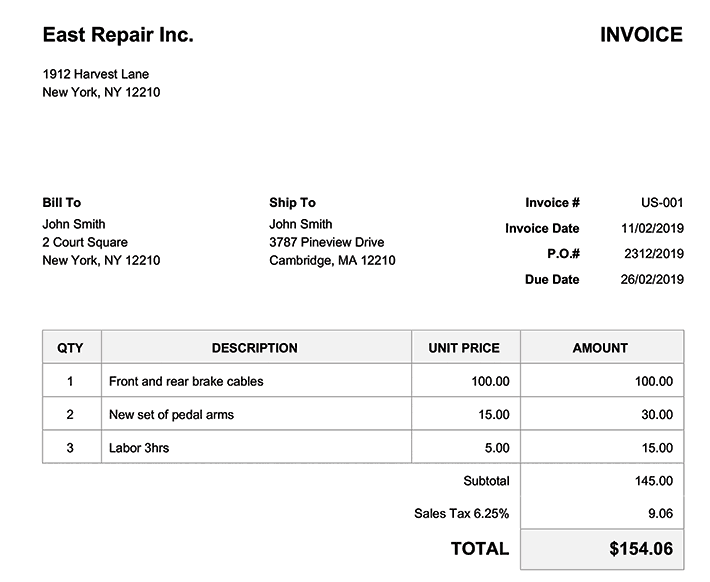

In [11]:
image

In [12]:
image_file = '/kaggle/working/examples_invoice.png'

# plain texts OCR
res = model.chat(tokenizer, image_file, ocr_type='ocr')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


In [13]:
res

'East Repair Inc.  IN VOICE 1912 Harvest Lane New York, NY 12210 Bill To Ship To In voice#  US- 001 John Smith John Smith In voice Date 11/02/2019 2 Court Square 3787 Pine view Drive New York, NY 12210 P. O. #  2312/2019 Cambridge, MA 12210 Due Date 26/02/2019 Q TY DESCRIPTION UNIT PRICE AMOUNT 1 Front and rear brake cables 100.00 100.00 2 New set of pedal arms 15.00 30.00 3 Labor 3 hrs 5.00 15.00 Subtotal 145.00 Sales Tax 6.25%  9.06 TOTAL $ 154.06'

In [14]:
res = model.chat(tokenizer, image_file, ocr_type='format')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


In [15]:
res

'\\begin{tabular}{|c|c|c|c|}\n\\hline \\multicolumn{2}{|c|}{ East Repair Inc. } & \\multicolumn{2}{|c|}{ INVOICE } \\\\\n\\hline \\multicolumn{4}{|c|}{ 1912 Harvest Lane } \\\\\n\\hline \\multicolumn{4}{|c|}{ New York, NY 12210 } \\\\\n\\hline Bill To & Ship To & Invoice \\# & US-001 \\\\\n\\hline John Smith & John Smith & Invoice Date & 11/02/2019 \\\\\n\\hline 2 Court Square & 3787 Pineview Drive & P.O.\\# & 2312/2019 \\\\\n\\hline New York, NY 12210 & Cambridge, MA 12210 & Due Date & 26/02/2019 \\\\\n\\hline QTY & DESCRIPTION & UNIT PRICE & AMOUNT \\\\\n\\hline 1 & Front and rear brake cables & 100.00 & 100.00 \\\\\n\\hline 2 & New set of pedal arms & 15.00 & 30.00 \\\\\n\\hline 3 & Labor 3hrs & 5.00 & 15.00 \\\\\n\\hline & & Subtotal & 145.00 \\\\\n\\hline & & Sales Tax 6.25\\% & 9.06 \\\\\n\\hline & & TOTAL & \\(\\$ 154.06\\) \\\\\n\\hline\n\\end{tabular}'

In [16]:
res = model.chat(tokenizer, image_file, ocr_type='format', render=True, save_render_file = './demo.html')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


==============rendering===============


In [17]:
res

'\\begin{tabular}{|c|c|c|c|}\n\\hline \\multicolumn{2}{|c|}{ East Repair Inc. } & \\multicolumn{2}{|c|}{ INVOICE } \\\\\n\\hline \\multicolumn{4}{|c|}{ 1912 Harvest Lane } \\\\\n\\hline \\multicolumn{4}{|c|}{ New York, NY 12210 } \\\\\n\\hline Bill To & Ship To & Invoice \\# & US-001 \\\\\n\\hline John Smith & John Smith & Invoice Date & 11/02/2019 \\\\\n\\hline 2 Court Square & 3787 Pineview Drive & P.O.\\# & 2312/2019 \\\\\n\\hline New York, NY 12210 & Cambridge, MA 12210 & Due Date & 26/02/2019 \\\\\n\\hline QTY & DESCRIPTION & UNIT PRICE & AMOUNT \\\\\n\\hline 1 & Front and rear brake cables & 100.00 & 100.00 \\\\\n\\hline 2 & New set of pedal arms & 15.00 & 30.00 \\\\\n\\hline 3 & Labor 3hrs & 5.00 & 15.00 \\\\\n\\hline & & Subtotal & 145.00 \\\\\n\\hline & & Sales Tax 6.25\\% & 9.06 \\\\\n\\hline & & TOTAL & \\(\\$ 154.06\\) \\\\\n\\hline\n\\end{tabular}'

In [18]:
image = load_image("/kaggle/input/ocr-test/2505.17612v1_page-0006.jpg")

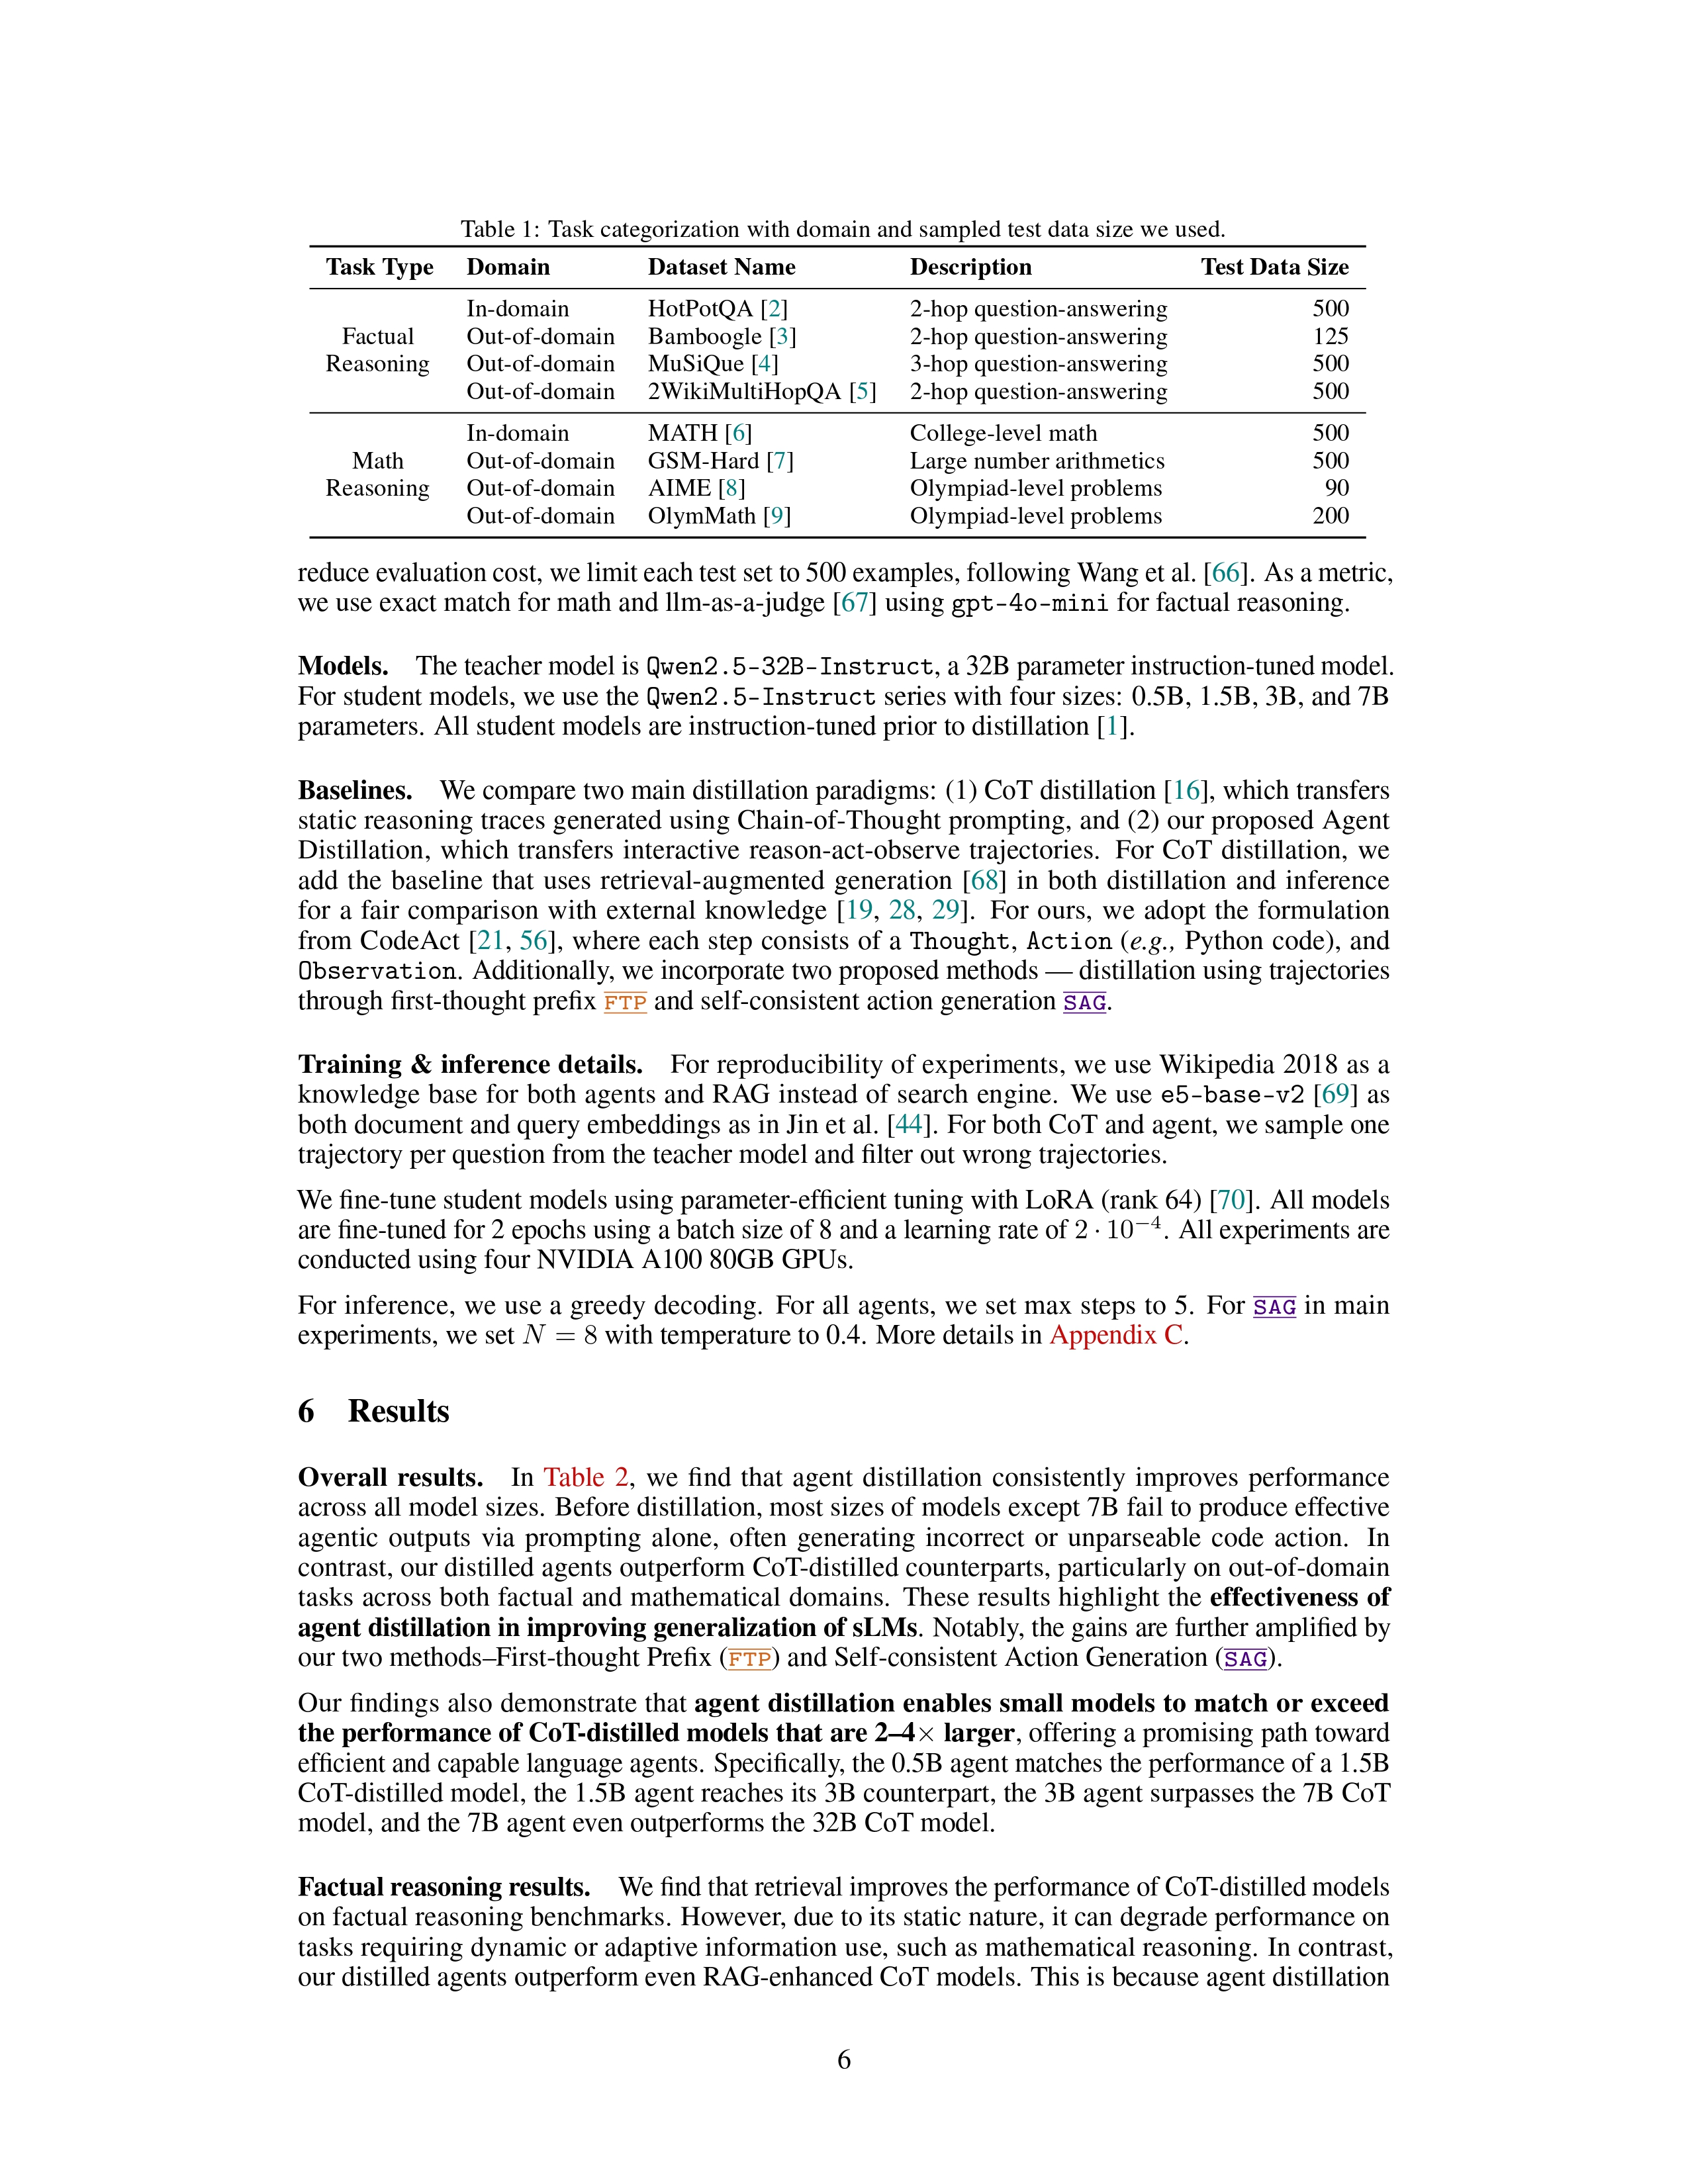

In [19]:
image

In [20]:
image_file = "/kaggle/input/ocr-test/2505.17612v1_page-0006.jpg"

In [21]:
res = model.chat(tokenizer, image_file, ocr_type='format', render=True, save_render_file = './demo_2.html')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


==============rendering===============


In [22]:
res

'Table 1: Task categorization with domain and sampled test data size we used.\n\\begin{tabular}{|c|c|c|c|c|}\n\\hline Task Type & Domain & Dataset Name & Description & Test Data Size \\\\\n\\hline \\multirow{3}{*}{\\begin{tabular}{l} \nFactual \\\\\nReasoning\n\\end{tabular}} & \\begin{tabular}{l} \nIn-domain \\\\\nOut-of-domain \\\\\nOut-of-domain\n\\end{tabular} & \\begin{tabular}{l} \nHotPoTQA  \\\\\nBamboogle\n\\end{tabular} & \\begin{tabular}{l} \n2-hop question-answering \\\\\n2-hop question-answering \\\\\n3-hop question-answering \\\\\n2-hop question-answering\n\\end{tabular} & \\begin{tabular}{l}\n500 \\\\\n125 \\\\\n500\n\\end{tabular} \\\\\n\\hline & Out-of-domain & 2WikiMultiHopQA  & 2-hop question-answering & 500 \\\\\n\\hline \\multirow{3}{*}{\\begin{tabular}{l}\n\\(\\quad\\) Math \\\\\nReasoning\n\\end{tabular}} & \\begin{tabular}{l}  \nIn-domain \\\\\nOut-of-domain \\\\\nOut-of-domain\n\\end{tabular} & \\(\\frac{\\text { MATH  }}{\\text { GSM-Hard  }}\\) & \\begin{tabul

In [23]:
print(res)

Table 1: Task categorization with domain and sampled test data size we used.
\begin{tabular}{|c|c|c|c|c|}
\hline Task Type & Domain & Dataset Name & Description & Test Data Size \\
\hline \multirow{3}{*}{\begin{tabular}{l} 
Factual \\
Reasoning
\end{tabular}} & \begin{tabular}{l} 
In-domain \\
Out-of-domain \\
Out-of-domain
\end{tabular} & \begin{tabular}{l} 
HotPoTQA  \\
Bamboogle
\end{tabular} & \begin{tabular}{l} 
2-hop question-answering \\
2-hop question-answering \\
3-hop question-answering \\
2-hop question-answering
\end{tabular} & \begin{tabular}{l}
500 \\
125 \\
500
\end{tabular} \\
\hline & Out-of-domain & 2WikiMultiHopQA  & 2-hop question-answering & 500 \\
\hline \multirow{3}{*}{\begin{tabular}{l}
\(\quad\) Math \\
Reasoning
\end{tabular}} & \begin{tabular}{l}  
In-domain \\
Out-of-domain \\
Out-of-domain
\end{tabular} & \(\frac{\text { MATH  }}{\text { GSM-Hard  }}\) & \begin{tabular}{l} 
College-level math \\
Large number arithmetics \\
Olympiad-level problems \\
Olympia

In [26]:
res = model.chat(tokenizer, image_file, ocr_type='format')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


In [27]:
print(res)

Table 1: Task categorization with domain and sampled test data size we used.
\begin{tabular}{|c|c|c|c|c|}
\hline Task Type & Domain & Dataset Name & Description & Test Data Size \\
\hline \multirow{3}{*}{\begin{tabular}{l} 
Factual \\
Reasoning
\end{tabular}} & \begin{tabular}{l} 
In-domain \\
Out-of-domain \\
Out-of-domain
\end{tabular} & \begin{tabular}{l} 
HotPoTQA  \\
Bamboogle
\end{tabular} & \begin{tabular}{l} 
2-hop question-answering \\
2-hop question-answering \\
3-hop question-answering \\
2-hop question-answering
\end{tabular} & \begin{tabular}{l}
500 \\
125 \\
500
\end{tabular} \\
\hline & Out-of-domain & 2WikiMultiHopQA  & 2-hop question-answering & 500 \\
\hline \multirow{3}{*}{\begin{tabular}{l}
\(\quad\) Math \\
Reasoning
\end{tabular}} & \begin{tabular}{l}  
In-domain \\
Out-of-domain \\
Out-of-domain
\end{tabular} & \(\frac{\text { MATH  }}{\text { GSM-Hard  }}\) & \begin{tabular}{l} 
College-level math \\
Large number arithmetics \\
Olympiad-level problems \\
Olympia